In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/chest_xray"

import os, shutil, random, glob, zipfile, pathlib
from pathlib import Path

assert os.path.exists(DATASET_DIR), f"Path not found: {DATASET_DIR}"
print("Using dataset root:", DATASET_DIR)


Mounted at /content/drive
Using dataset root: /content/drive/MyDrive/chest_xray


In [3]:
import os, zipfile, glob, random, shutil
from pathlib import Path

def maybe_unzip(root):
    zips = glob.glob(os.path.join(root, "*.zip"))
    if zips:
        for z in zips:
            print("Unzipping:", z)
            with zipfile.ZipFile(z, 'r') as zip_ref:
                zip_ref.extractall(root)

maybe_unzip(DATASET_DIR)
candidates = [
    DATASET_DIR,
    os.path.join(DATASET_DIR, "chest_xray"),
]

def has_split(root):
    return all(os.path.isdir(os.path.join(root, s)) for s in ["train","val","test"])

ROOT = None
for c in candidates:
    if has_split(c):
        ROOT = c
        break

if ROOT is None:
    for c in candidates:
        if all(os.path.isdir(os.path.join(c, s)) for s in ["train","test"]):
            ROOT = c
            val_dir = os.path.join(ROOT, "val")
            os.makedirs(val_dir, exist_ok=True)
            for cls in os.listdir(os.path.join(ROOT, "train")):
                src = os.path.join(ROOT, "train", cls)
                dst = os.path.join(val_dir, cls)
                os.makedirs(dst, exist_ok=True)
                files = [f for f in glob.glob(os.path.join(src, "*")) if os.path.isfile(f)]
                random.shuffle(files)
                take = max(1, int(0.1*len(files)))
                for f in files[:take]:
                    shutil.move(f, os.path.join(dst, os.path.basename(f)))
            break

if ROOT is None:
    classes = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
    if set(map(str.lower, classes)) >= {"normal","pneumonia"}:
        ROOT = os.path.join(DATASET_DIR, "_split")
        if not os.path.exists(ROOT):
            print("Creating train/val/test splits (80/10/10) from flat class folders...")
            for split in ["train","val","test"]:
                for cls in classes:
                    os.makedirs(os.path.join(ROOT, split, cls), exist_ok=True)
            for cls in classes:
                files = [f for f in glob.glob(os.path.join(DATASET_DIR, cls, "*")) if os.path.isfile(f)]
                random.shuffle(files)
                n = len(files)
                n_train = int(0.8*n); n_val = int(0.1*n)
                for i,f in enumerate(files):
                    if i < n_train:
                        dst = os.path.join(ROOT, "train", cls, os.path.basename(f))
                    elif i < n_train + n_val:
                        dst = os.path.join(ROOT, "val", cls, os.path.basename(f))
                    else:
                        dst = os.path.join(ROOT, "test", cls, os.path.basename(f))
                    shutil.copy2(f, dst)

assert ROOT is not None, "Could not detect a valid dataset structure. Ensure folders are one of the expected layouts."
print("Detected dataset root with splits:", ROOT)
!find "$ROOT" -maxdepth 2 -type d -print


Detected dataset root with splits: /content/drive/MyDrive/chest_xray
/content/drive/MyDrive/chest_xray
/content/drive/MyDrive/chest_xray/val
/content/drive/MyDrive/chest_xray/val/NORMAL
/content/drive/MyDrive/chest_xray/val/PNEUMONIA
/content/drive/MyDrive/chest_xray/test
/content/drive/MyDrive/chest_xray/test/NORMAL
/content/drive/MyDrive/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/chest_xray/chest_xray
/content/drive/MyDrive/chest_xray/chest_xray/val
/content/drive/MyDrive/chest_xray/chest_xray/train
/content/drive/MyDrive/chest_xray/chest_xray/test
/content/drive/MyDrive/chest_xray/__MACOSX
/content/drive/MyDrive/chest_xray/__MACOSX/chest_xray
/content/drive/MyDrive/chest_xray/train
/content/drive/MyDrive/chest_xray/train/NORMAL
/content/drive/MyDrive/chest_xray/train/PNEUMONIA


In [4]:
import os, torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(os.path.join(ROOT,"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(ROOT,"val"),   transform=val_tfms)
test_ds  = datasets.ImageFolder(os.path.join(ROOT,"test"),  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
len(train_ds), len(val_ds), len(test_ds), class_names


(5216, 16, 624, ['NORMAL', 'PNEUMONIA'])

In [5]:
import torch
from collections import Counter

targets = [y for _, y in train_ds.samples]
counts = Counter(targets)
num_classes = len(class_names)
total = sum(counts.values())
class_weights = torch.zeros(num_classes, dtype=torch.float)
for c in range(num_classes):
    class_weights[c] = total / (num_classes * counts[c])
print("Class counts:", counts)
print("Class weights:", class_weights)


Class counts: Counter({1: 3875, 0: 1341})
Class weights: tensor([1.9448, 0.6730])


In [7]:

import torch, torch.nn as nn, torch.optim as optim
from torchvision import models
from tqdm.auto import tqdm
import os

PROJECT_NAME = "pneumonia_resnet_colab"
DRIVE_DIR = f"/content/drive/MyDrive/{PROJECT_NAME}"
os.makedirs(DRIVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    num_workers = 2
    pin_memory = True
    persistent = True
else:
    num_workers = 0
    pin_memory = False
    persistent = False
ARCH = "resnet50"
LR = 1e-3
WD = 1e-4
FREEZE_BACKBONE_EPOCHS = 1
EPOCHS = 8

if ARCH == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_features = model.fc.in_features
else:
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    in_features = model.fc.in_features

model.fc = nn.Linear(in_features, len(class_names))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

if FREEZE_BACKBONE_EPOCHS > 0:
    for name, p in model.named_parameters():
        if not name.startswith("fc."):
            p.requires_grad = False
print("Device:", DEVICE, "| Backbone frozen for first", FREEZE_BACKBONE_EPOCHS, "epochs")

best_val_acc = 0.0
history = {"train_loss":[], "val_acc":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - train"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    if epoch == FREEZE_BACKBONE_EPOCHS:
        for p in model.parameters(): p.requires_grad = True
        print("Unfroze backbone.")

    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} - val"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total if total>0 else 0.0
    scheduler.step(val_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(DRIVE_DIR, f"best_{ARCH}.pth"))
        print("Saved new best model to Drive.")

print("Best val acc:", best_val_acc)


Device: cuda | Backbone frozen for first 1 epochs


Epoch 1/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Unfroze backbone.


Epoch 1/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: train_loss=0.3147  val_acc=0.8750


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


Saved new best model to Drive.


Epoch 2/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2: train_loss=0.1597  val_acc=0.5625


Epoch 3/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3: train_loss=0.1177  val_acc=0.6875


Epoch 4/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^

   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
      ^ ^^^ ^^^ ^ ^  ^  ^^^
^  File "/u

Epoch 4/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0> 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
^  ^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^^   ^ ^ ^^
^  File "/u

Epoch 4: train_loss=0.0736  val_acc=1.0000


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12

Saved new best model to Drive.


Epoch 5/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0676  val_acc=0.7500


Epoch 6/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0650  val_acc=0.6875


Epoch 7/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0547  val_acc=0.6250


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67299dbc0>self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
if w.is_alive():    self._shutdown_workers()
 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      
 if w.is_alive():    ^ ^ ^  ^ ^Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, i

Epoch 8/8 - train:   0%|          | 0/163 [00:00<?, ?it/s]

 ^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

                   ^  ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process

AssertionError: Traceback (most recent call last):
can only test a child process
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
Exception in thread   File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
QueueFeederThread:
Traceback (most recent call last):
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.12/multiprocessing/qu

Epoch 8/8 - val:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0375  val_acc=1.0000
Best val acc: 1.0


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 270, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exc

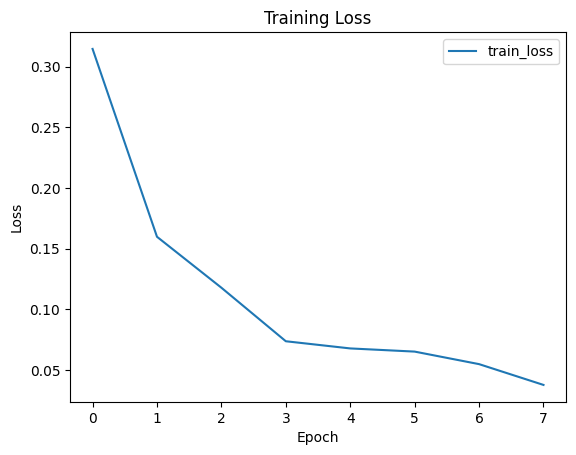

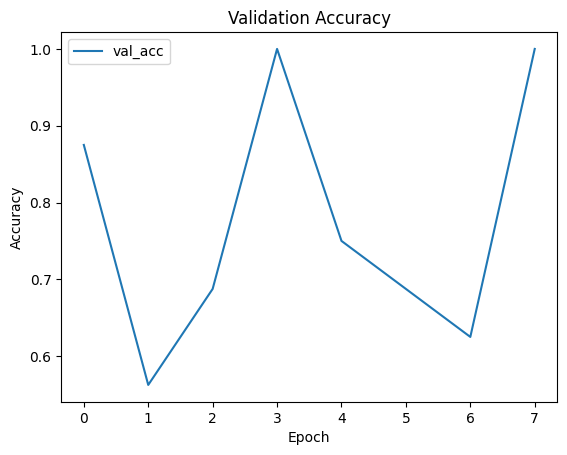

Classes: ['NORMAL', 'PNEUMONIA']
              precision    recall  f1-score   support

      NORMAL       0.91      0.70      0.79       234
   PNEUMONIA       0.84      0.96      0.90       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624

Confusion Matrix:
 [[164  70]
 [ 17 373]]


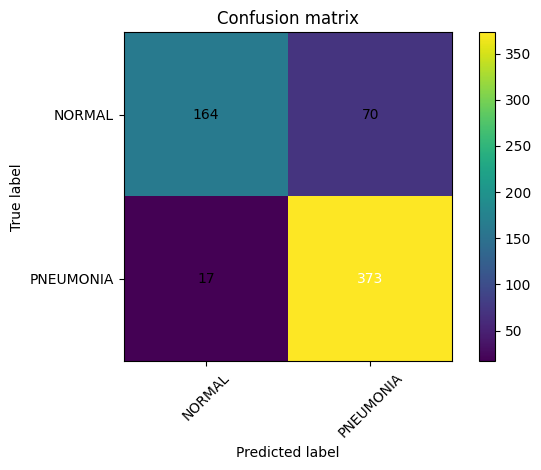

ROC AUC: 0.937979399517861


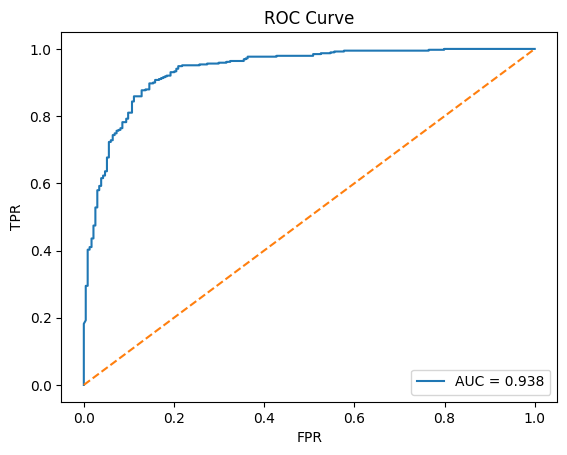

In [8]:

import matplotlib.pyplot as plt, numpy as np, torch, os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

plt.figure(); plt.plot(history["train_loss"], label="train_loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.savefig(os.path.join(DRIVE_DIR,"training_loss.png")); plt.show()
plt.figure(); plt.plot(history["val_acc"], label="val_acc"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy"); plt.legend(); plt.savefig(os.path.join(DRIVE_DIR,"val_accuracy.png")); plt.show()

state_dict_path = os.path.join(DRIVE_DIR, f"best_{ARCH}.pth")
model.load_state_dict(torch.load(state_dict_path, map_location=DEVICE))
model.eval()

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        if len(class_names)==2:
            all_probs.extend(probs[:,1])

print("Classes:", class_names)
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

import itertools
plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion matrix'); plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45); plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i,j]}", ha="center", va="center", color="white" if cm[i,j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.savefig(os.path.join(DRIVE_DIR, "confusion_matrix.png")); plt.show()

if len(class_names)==2 and len(all_probs)==len(all_labels):
    auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    print("ROC AUC:", auc)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(loc="lower right"); plt.savefig(os.path.join(DRIVE_DIR,"roc_curve.png")); plt.show()
